In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
def kmeans(X, k=3, n_iterations=100, thres=0.0001):
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]
    previous_centroids = centroids.copy()

    for j in range(n_iterations):
        distances = np.sum(np.sqrt((X - centroids[:, np.newaxis])**2), axis=2)
        closest_cluster = np.argmin(distances, axis=0)
        
        for i in range(k):
            centroids[i] = X[closest_cluster == i].mean(axis=0)
        
        if np.all(np.abs(previous_centroids - centroids) <= thres):
            break
        previous_centroids = centroids.copy()
    return closest_cluster, centroids

def kmeans_objective(X, labels, centroids):
    distance = np.sum([np.sum((X[labels == i] - centroids[i])**2) for i in range(centroids.shape[0])])
    return distance


In [3]:
def initialize_gmm(X, k=3):
    n_samples = X.shape[0]
    labels = np.random.choice(k, n_samples)
    means = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    covariances = np.array([np.cov(X[labels == i].T) for i in range(k)])
    pis = np.array([np.mean(labels == i) for i in range(k)])
    return pis, means, covariances

def gmm_em(X, k=3, n_iterations=100, thres=0.0001):
    pis, means, covariances = initialize_gmm(X, k)
    n_samples = X.shape[0]
    
    for i in range(n_iterations):
        # E-step
        respon = np.zeros((X.shape[0], k))

        for j in range(k):
            rv = multivariate_normal(mean=means[j], cov=covariances[j])
            respon[:, j] = pis[j] * rv.pdf(X)
        respon = respon.T
        respon_sums = respon.sum(axis=0)
        respon = (respon / respon_sums).T

        # M-step
        Nk = respon.sum(axis=0)
        pis = Nk / n_samples

        means = np.zeros((k, X.shape[1]))
        for j in range(k):
            weights = respon[:, j][:, np.newaxis] 
            weighted_sum = np.sum(weights * X, axis=0)
            means[j] = weighted_sum / Nk[j]

        covariances = np.zeros((k, X.shape[1], X.shape[1]))
        for j in range(k):
            weights = respon[:, j][:, np.newaxis]
            deviation = X - means[j]
            weighted_deviation = weights * deviation
            covariance_matrix = weighted_deviation.T @ deviation
            covariances[j] = covariance_matrix / Nk[j]

        if max(Nk - pis * n_samples) <= thres:
            break
    
    return pis, means, covariances, respon

def gmm_log_likelihood(X, pis, means, covariances):
    likelihoods = np.zeros(X.shape[0])
    for j in range(pis.size):
        pdf_values = multivariate_normal.pdf(X, mean=means[j], cov=covariances[j])
        weighted_pdf_values = pis[j] * pdf_values
        likelihoods += weighted_pdf_values

    log_likelihood = np.sum(np.log(likelihoods))
    return log_likelihood


In [4]:
def generate_data(sigma, n_points=100):
    mean_a = np.array([-1, -1])
    mean_b = np.array([1, -1])
    mean_c = np.array([0, 1])
    
    cov_a = sigma * np.array([[2, 0.5], [0.5, 1]])
    cov_b = sigma * np.array([[1, -0.5], [-0.5, 2]])
    cov_c = sigma * np.array([[1, 0], [0, 2]])
    
    a = np.random.multivariate_normal(mean_a, cov_a, n_points)
    b = np.random.multivariate_normal(mean_b, cov_b, n_points)
    c = np.random.multivariate_normal(mean_c, cov_c, n_points)
    
    X = np.vstack((a, b, c))
    y = np.array([0]*n_points + [1]*n_points + [2]*n_points)  # True labels
    return X, y

def map_labels(cluster_labels, true_labels):
    from scipy.stats import mode

    labels = np.zeros_like(cluster_labels)
    for i in range(3):
        mask = (cluster_labels == i)
        labels[mask] = mode(true_labels[mask])[0]
    return labels

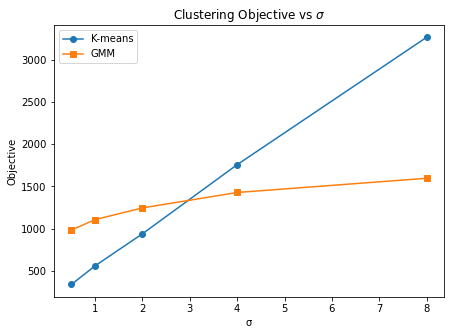

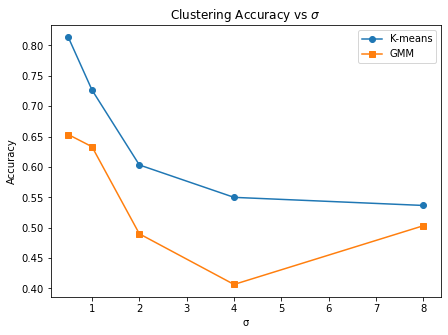

In [5]:
sigmas = [0.5, 1, 2, 4, 8]
kmeans_objectives = []
gmm_objectives = []
kmeans_accuracies = []
gmm_accuracies = []

for sigma in sigmas:
    X, y = generate_data(sigma)
    
    best_kmeans_score = np.inf
    for i in range(10):
        cluster_labels, centroids = kmeans(X)
        score = kmeans_objective(X, cluster_labels, centroids)
        if score < best_kmeans_score:
            best_kmeans_score = score
            best_kmeans_labels = cluster_labels
    mapped_labels = map_labels(best_kmeans_labels, y)
    kmeans_accuracies.append(accuracy_score(y, mapped_labels))
    kmeans_objectives.append(best_kmeans_score)
    

    best_gmm_score = -np.inf
    for i in range(10): 
        pis, means, covariances, respon = gmm_em(X)
        score = gmm_log_likelihood(X, pis, means, covariances)
        if score > best_gmm_score:
            best_gmm_score = score
            best_gmm_labels = np.argmax(respon, axis=1)
    mapped_labels = map_labels(best_gmm_labels, y)
    gmm_accuracies.append(accuracy_score(y, mapped_labels))
    gmm_objectives.append(-best_gmm_score)


fig1 = plt.figure(figsize=(7, 5))
plt.plot(sigmas, kmeans_objectives, marker='o', label='K-means')
plt.plot(sigmas, gmm_objectives, marker='s', label='GMM')
plt.xlabel('σ')
plt.ylabel('Objective')
plt.title('Clustering Objective vs $\sigma$')
plt.legend()
plt.show()
fig1.savefig('q1-2_objective vs sigma.png', dpi=300)

fig2 = plt.figure(figsize=(7, 5))
plt.plot(sigmas, kmeans_accuracies, marker='o', label='K-means')
plt.plot(sigmas, gmm_accuracies, marker='s', label='GMM')
plt.xlabel('σ')
plt.ylabel('Accuracy')
plt.title('Clustering Accuracy vs $\sigma$')
plt.legend()
plt.show()
fig2.savefig('q1-2_accuracy vs sigma.png', dpi=300)
